# Map differential selection to structures

We generated pymol scripts to display positive differential selection values on various PB2 structures.

Structure | pdb name | Input txt files | Output pymol scripts
--- | --- | --- | ---
Polymerase in transcription pre-initiation form | 4wsb | preamble <br/> setview <br/> colorfullstructure <br/> topA549 | map_fullstructure.py <br/> map_topA549.py <br/> map_positive_diff_seq.py 
Polymerase in apo form | 59d8 | preamble <br/> setview <br/> colorfullstructure <br/> topA549 | map_fullstructure.py <br/> map_topA549.py <br/> map_positive_diff_seq.py 
PB2 in complex with RNA pol II | 6f5o | preamble <br/> setview <br/> MartinResidues <br/> topA549 | map_MartinResidues.py <br/> map_positive_diff_seq.py
PB2 in complex with importin | 4uae | preamble <br/> setview <br/> PumroyResidues <br/> topA549 | map_PumroyResidues.py <br/> map_positive_diff_seq.py

Import modules, define directories

In [1]:
import os
import shutil
import pandas as pd
import numpy as np
from colour import Color

import dms_tools2
import dms_tools2.dssp

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.3)

In [2]:
## Set plotting parameters/preferences
# Set matplotlib rcParams for figures
import seaborn as sns
sns.set(context='paper', style='ticks', palette='deep', font='Arial', font_scale=1.042, color_codes=True,
        rc = {'font.size': 10,
 'axes.labelsize': 10,
 'axes.titlesize': 10,
 'xtick.labelsize': 9,
 'ytick.labelsize': 9,
 'legend.fontsize': 9,
 'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1,
 'lines.markersize': 4.5,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.5,
 'ytick.major.size': 4.5,
 'xtick.minor.size': 3,
 'ytick.minor.size': 3}
       )
palette ={"None":"gray",
          "A549":"#d95f02",
         }
# sns.plotting_context()

Generate `topA549.txt`

In [3]:
# Gather prior annotations for known human/mammalian adaptive mutations
mutsAdaptive = pd.read_table('data/Muts_HumanAvian.txt')
knownAdaptive = (set(mutsAdaptive[mutsAdaptive['ExptVerified']=='Yes']['Site']))
# Gather top adaptive mutations in A549
dmssummarydf = pd.read_csv('results/diffsel/summary_prefs_effects_diffsel.csv')
topA549 = (set(dmssummarydf[dmssummarydf['Experimentally adaptive in']=='A549']['site']))
# Intersect
knownAdaptiveAndTopA549 = (knownAdaptive & topA549)

# Set colors for each set of mutations
mutsets = [((knownAdaptive, 'knownAdaptive'), 'blue'), 
           ((topA549, 'topA549'), 'red'), 
           ((knownAdaptiveAndTopA549, 'knownAdaptiveAndTopA549'), 'magenta')]

# Write to file
outfile = 'pymol/topA549.txt'
f = open(outfile, 'w')
f.write('metric = \'topA549\'\n')
f.write('cmd.color(\'white\', \'S009\')\n\n')
for ((mutlist, mutlistname), col) in mutsets:
    f.write('# {0}\n'.format(mutlistname))
    f.write('for r in [{0}]:\n'.format(', '.join([str(mut) for mut in mutlist])))
    f.write('\tcmd.color(\'{0}\', \'resi {{0}} and S009\'.format(r))\n'.format(col))
    f.write('\tcmd.show(\'spheres\', \'resi {{0}} and S009\'.format(r))\n\n')
f.close()

Generate pymol scripts

In [4]:
# Standard across all structures
postamble = 'pymol/postamble.txt'
fullstructure = 'pymol/colorfullstructure.txt'
topA549 = 'pymol/topA549.txt'
pumroy = 'pymol/PumroyResidues.txt'
martin = 'pymol/MartinResidues.txt'
specialmetricfiles = {'fullstructure': fullstructure,
                     'topA549': topA549, 
                     'pumroy': pumroy,
                     'martin': martin}
# For non-specialmetrics
diffsel_file = 'results/diffsel/summary_A549vCCL141-meansitediffsel.csv'
metricdf = pd.read_csv(diffsel_file).sort_values('site')
colspectrum = 'white_red'

def write_pymol_script(structure, metric, metricdf, colspectrum):
    outfile = 'pymol/{0}_map_{1}.py'.format(structure, metric)
    preamble = 'pymol/preamble_{0}.txt'.format(structure)
    setview = 'pymol/setviewamble_{0}.txt'.format(structure)

    f = open(outfile, 'w')

    with open(preamble, 'r') as addtext:
        for line in addtext.readlines():
            f.write(line)
            if metric=='fullstructure' and line=='### To get PB2 only\n': 
                #don't print lines that will remove non-PB2 subunits
                break
        f.write('\n\n')
    
    # Write commands to color structure
    if metric in specialmetricfiles:
        with open(specialmetricfiles[metric], 'r') as addtext:
            for line in addtext.readlines():
                f.write(line)
            f.write('\n\n')
    else:
        f.write("metric = \'{0}\'\n".format(metric))
        for row in metricdf.itertuples(index=True, name='Pandas'):
            site, met = (getattr(row, "site"), getattr(row, metric))
            f.write("cmd.alter(\'resi {0}\', \'b = {1}\')\n".format(site, met))
        f.write('\n')
        f.write("cmd.spectrum(\'b\', \'{0}\', \'S009\')\n".format(colspectrum))
        f.write('\n')

    with open(setview, 'r') as addtext:
        for line in addtext.readlines():
            f.write(line)
    f.write('\n')
    with open(postamble, 'r') as addtext:
        for line in addtext.readlines():
            f.write(line)

    f.close()

In [5]:
structures = ['4wsb', '5d98']
metrics = ['fullstructure', 'topA549', 'positive_diffsel']

for structure in structures:
    for metric in metrics:
        write_pymol_script(structure, metric, metricdf, colspectrum)

In [6]:
structures = ['6f5o']
metrics = ['martin', 'positive_diffsel', 'topA549']

for structure in structures:
    for metric in metrics:
        write_pymol_script(structure, metric, metricdf, colspectrum)

In [7]:
structures = ['4uad']
metrics = ['pumroy', 'positive_diffsel', 'topA549']

for structure in structures:
    for metric in metrics:
        write_pymol_script(structure, metric, metricdf, colspectrum)

## Are differentially selected residues on the surface of PB2/polymerase? 

Calculate RSA for top A549 differentially selected residues.

In [8]:
# Manually generate new pdb files for S009-PB2 superimposed on 4wsb and 5d98 structures, using following scripts.
# S009-PB2 is saved as chain X.
# For each structure, I made two files: one with only PB2, and one with PB2 as part of polymerase complex.
!ls pymol/*superS009.py

pymol/4wsb_superS009.py  pymol/5d98_superS009.py


In [9]:
# Convert the following files to dssp: https://swift.cmbi.umcn.nl/gv/dssp/
!ls pymol/*superS009*pdb

pymol/4wsb_superS009.pdb	   pymol/5d98_superS009.pdb
pymol/4wsb_superS009_S009only.pdb  pymol/5d98_superS009_S009only.pdb


In [10]:
# Converted to dssp
!ls pymol/*superS009*dssp

pymol/4wsb_superS009.dssp	    pymol/5d98_superS009.dssp
pymol/4wsb_superS009_S009only.dssp  pymol/5d98_superS009_S009only.dssp


In [11]:
dssplist = []
structures = ['4wsb', '5d98']
contexts = [('full pol', ''), ('S009 only', '_S009only')]
for structure in structures:
    for context, contextlab in contexts:
        dsspdf = dms_tools2.dssp.processDSSP('pymol/{0}_superS009{1}.dssp'.format(structure, contextlab), chain='X')
        dsspdf['structure'] = structure
        dsspdf['context'] = context
        dssplist.append(dsspdf)
dssps = pd.concat(dssplist)
print(dssps.head())
# Gather annotations of mutations (known, novel)
annot = pd.read_csv('results/diffsel/summary_prefs_effects_diffsel.csv')[['site', 'Experimentally adaptive in']]
annot = annot[annot['Experimentally adaptive in']=='A549'].drop_duplicates()
print(annot.head())

dssps = pd.merge(left=dssps, right=annot, on='site', how='left')
dssps.fillna('None', inplace=True)

   site amino_acid  ASA       RSA SS SS_class structure   context
0     1          M  104  0.464286  -     loop      4wsb  full pol
1     2          E  155  0.695067  H    helix      4wsb  full pol
2     3          R   61  0.222628  H    helix      4wsb  full pol
3     4          I    3  0.015228  H    helix      4wsb  full pol
4     5          K   77  0.326271  H    helix      4wsb  full pol
      site Experimentally adaptive in
921    163                       A549
1385   627                       A549
1459   701                       A549
1700   183                       A549
2049   532                       A549


In [12]:
dssps[dssps['site']==1]

,site,amino_acid,ASA,RSA,SS,SS_class,structure,context,Experimentally adaptive in
0,1,M,104,0.464286,-,loop,4wsb,full pol,None
733,1,M,162,0.723214,-,loop,4wsb,S009 only,None
1466,1,M,95,0.424107,-,loop,5d98,full pol,None
2221,1,M,157,0.700893,-,loop,5d98,S009 only,None


In [13]:
dssp_4wsb = pd.merge(left=dssps[(dssps['structure']=='4wsb') & (dssps['context']=='full pol')][['site', 'amino_acid', 'Experimentally adaptive in', 'RSA']],
                    right=dssps[(dssps['structure']=='4wsb') & (dssps['context']=='S009 only')][['site', 'amino_acid', 'Experimentally adaptive in', 'RSA']],
                    on=['site', 'amino_acid', 'Experimentally adaptive in'],
                    suffixes=['_4wsbfullpol','_4wsbS009only']
                   )

dssp_5d98 = pd.merge(left=dssps[(dssps['structure']=='5d98') & (dssps['context']=='full pol')][['site', 'amino_acid', 'Experimentally adaptive in', 'RSA']],
                    right=dssps[(dssps['structure']=='5d98') & (dssps['context']=='S009 only')][['site', 'amino_acid', 'Experimentally adaptive in', 'RSA']],
                    on=['site', 'amino_acid', 'Experimentally adaptive in'],
                    suffixes=['_5d98fullpol','_5d98S009only']
                   )

dsspwide = pd.merge(left=dssp_4wsb, right=dssp_5d98,on=['site', 'amino_acid', 'Experimentally adaptive in'])
dsspwide.head()

,site,amino_acid,Experimentally adaptive in,RSA_4wsbfullpol,RSA_4wsbS009only,RSA_5d98fullpol,RSA_5d98S009only
0,1,M,None,0.464286,0.723214,0.424107,0.700893
1,2,E,None,0.695067,0.695067,0.663677,0.663677
2,3,R,None,0.222628,0.773723,0.445255,0.791971
3,4,I,None,0.015228,0.512690,0.035533,0.614213
4,5,K,None,0.326271,0.457627,0.309322,0.347458


In [14]:
def scatterplotRSA(df, hue, x, xlab, y, ylab):
    hue_order = ['None', 'A549']
    hue_kws = dict(alpha=[0.2,1], facecolors=[None,None], s=[20,20], linewidths=[1,1], marker=["o","o"])
    lowlim, highlim = -0.05, 1.05
    g = sns.FacetGrid(df, height=3, aspect=1,
                      hue=hue, hue_order=hue_order, hue_kws=hue_kws,
                      palette=palette, 
                      despine=False,
                     )
    g = (g.map(plt.scatter, x, y)
         .set_axis_labels(xlab, ylab)
         .set(xlim=(lowlim, highlim), ylim=(lowlim, highlim), 
             xticks=[0, 0.2, 0.4, 0.6, 0.8, 1], yticks=[0, 0.2, 0.4, 0.6, 0.8, 1])
        )
    plt.plot([0.2, 0.2], [lowlim, highlim], linewidth=1, color='b', alpha=0.5)
    plt.plot([lowlim, highlim], [0.2, 0.2], linewidth=1, color='b', alpha=0.5)
    plt.plot([lowlim, highlim], [lowlim, highlim], linewidth=1, color='b', alpha=0.5)

    resi_xy = zip(df[df[hue]=='A549'][x], df[df[hue]=='A549'][y])
    resi_sites = df[df[hue]=='A549']['site']
    residues = zip(resi_sites, resi_xy)
    for (resi_site, (resi_x, resi_y)) in residues:
        plt.text(resi_x+0.02, resi_y, resi_site, horizontalalignment='left', verticalalignment='bottom')
    plt.savefig('pymol/{0}_{1}.pdf'.format(x, y), dpi=300, bbox_inches='tight')
    

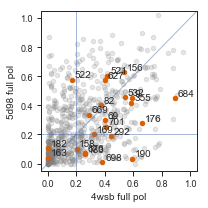

In [15]:
sns.set_style("ticks")
df = dsspwide
hue = 'Experimentally adaptive in'
x, xlab = 'RSA_4wsbfullpol', '4wsb full pol'
y, ylab = 'RSA_5d98fullpol', '5d98 full pol'
scatterplotRSA(df, hue, x, xlab, y, ylab)

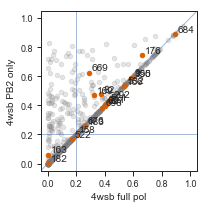

In [16]:
x, xlab = 'RSA_4wsbfullpol', '4wsb full pol'
y, ylab = 'RSA_4wsbS009only', '4wsb PB2 only'
scatterplotRSA(df, hue, x, xlab, y, ylab)

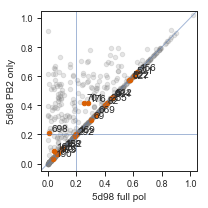

In [17]:
x, xlab = 'RSA_5d98fullpol', '5d98 full pol'
y, ylab = 'RSA_5d98S009only', '5d98 PB2 only'
scatterplotRSA(df, hue, x, xlab, y, ylab)

In [18]:
dsspwide[dsspwide['Experimentally adaptive in']=='A549']

,site,amino_acid,Experimentally adaptive in,RSA_4wsbfullpol,RSA_4wsbS009only,RSA_5d98fullpol,RSA_5d98S009only
8,9,D,A549,0.590674,0.590674,0.450777,0.450777
68,69,E,A549,0.399103,0.399103,0.300448,0.300448
81,82,N,A549,0.374359,0.476923,0.400000,0.400000
155,156,A,A549,0.534884,0.534884,0.627907,0.627907
157,158,E,A549,0.201794,0.201794,0.103139,0.103139
162,163,I,A549,0.000000,0.060914,0.040609,0.086294
168,169,P,A549,0.327044,0.471698,0.201258,0.201258
175,176,I,A549,0.659898,0.746193,0.279188,0.416244
181,182,Q,A549,0.004444,0.004444,0.106667,0.106667
182,183,L,A549,0.258706,0.258706,0.064677,0.064677


## Copy files to paper figures directory

In [19]:
paperdir = './paper'
figuresdir = os.path.join(paperdir, 'figures/')
myfiguresdir = os.path.join(figuresdir, 'Fig5/')
if not os.path.isdir(myfiguresdir):
    os.mkdir(myfiguresdir)

filespy = !ls pymol/*.py
filespdb = !ls pymol/*.pdb
filespdf = !ls pymol/*.pdf
for f in filespy + filespdb + filespdf:
    shutil.copy(f, myfiguresdir)
    

In [20]:
filespy + filespdb + filespdf

['pymol/4uad_map_positive_diffsel.py',
 'pymol/4uad_map_pumroy.py',
 'pymol/4uad_map_topA549.py',
 'pymol/4wsb_map_fullstructure.py',
 'pymol/4wsb_map_positive_diffsel.py',
 'pymol/4wsb_map_topA549.py',
 'pymol/4wsb_superS009.py',
 'pymol/5d98_map_fullstructure.py',
 'pymol/5d98_map_positive_diffsel.py',
 'pymol/5d98_map_topA549.py',
 'pymol/5d98_superS009.py',
 'pymol/6f5o_map_martin.py',
 'pymol/6f5o_map_positive_diffsel.py',
 'pymol/6f5o_map_topA549.py',
 'pymol/4wsb_superS009.pdb',
 'pymol/4wsb_superS009_S009only.pdb',
 'pymol/5d98_superS009.pdb',
 'pymol/5d98_superS009_S009only.pdb',
 'pymol/S009PB2_4uae.pdb',
 'pymol/S009PB2_4wsb.pdb',
 'pymol/S009PB2_5d98.pdb',
 'pymol/S009PB2_6f5o.pdb',
 'pymol/RSA_4wsbfullpol_RSA_4wsbS009only.pdf',
 'pymol/RSA_4wsbfullpol_RSA_5d98fullpol.pdf',
 'pymol/RSA_5d98fullpol_RSA_5d98S009only.pdf']